This notebook generates regional timeseries trend plots of annual number of fires (ANF) from AVHRR, and FWSL derived from the ensemble of GEFFs and GFWED outputs. Specifically:
* Figure S5 - extended materials plots for all GFED regions and biomes

**NOTE:** currently this notebook plots the FWSL over the top of the ANF, which is problematic visually as FWSL is plotted as a solid grey band. This is done because it makes most sense to have ANF on the left X-axis, as the focus of the study, and python defaults to plotting the second x-axis variable on top of the first - have not looked into a method to change this behaviour. This is issue is later fixed with manual postprocessing of the outputs using Adobe illustrator before inserting into the manuscript.

In [13]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

#custom
sys.path.append('./../../lib')
import paths as paths
import utils as utils

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [14]:
def ts_plotter_fw_flip(df, region_dict, ylab1, ylab2, xlab, av_color_list, fw_color_list, 
                       nrow, ncol, dim = None, ax2rm = None, xlabpad=0, sharex=False):
    """ 
    func for plotting AVHRR vs. meteo dual y-axis plots

    NOTE: there is redundant rounding going on here: both using np.round() and in string formatting
    this is a hangover from previous code iterations

    params:

    df: pandas dataframe, contains the fire count and vpd data to plot
    region_dict: dict, contains breakpoints for different regions (if applicable) 
    ylab1: str, left y axis label
    ylab2: str, right y axis label
    xlab: str, x axis label
    av_color_list: list, hex colours for plotting avhrr components
    fw_color_list: list, hex colours for plotting climate components
    nrow: int, dim of plot panels (n. rows) 
    ncol: int, dim of plot panels (n. columns)  
    dim: tuple of int, figure size. if None, defaults to (12,8)
    ax2rm: int, figure size. if not None, remove this many subaxes from the plot 
    xlabpad: float, pad the xaxis by this much 
    sharex: bool, share x axis, T or F? 
    
    returns:
    fig: figure object 
    axes: axes objects
    stats: df, summary stats 
    
    """
    
    eq_list = ['$\leq$', ' > ']
    
    if dim:
        pass
    else:
        dim=(12,8)      
    
    fig, axes = plt.subplots(figsize=dim, nrows=nrow, ncols=ncol,
                           squeeze=False, sharex=sharex,
                           gridspec_kw=dict(hspace=0.35, wspace=0.2))
    axes=axes.flatten()
    
    if ax2rm:   # delete excess axes
        for i in np.arange(ax2rm, 0):
            fig.delaxes(axes[i])
            
    statstable = pd.DataFrame({'region': [],'metric':[],
                           'year_start':[],'year_end' : [], 
                           'tau':[],'p':[],'intercept': [],
                           'slope':[],'lower':[],'upper':[],
                          })
    for i, (key, values) in enumerate(region_dict.items()):
        # print(i, key, values)
        ## if using all years of FW data ('df_outer'), need to remove the nans from matching AVHRR data to plot
        d_fw = df.loc[df.gfed_name==key].copy()
        d_av = df.loc[df.gfed_name==key].copy()    
        d_av = d_av.dropna()   

        x1 = d_fw['year'].values    
        y1 = d_fw['fdi_mean'].values
        y1n = d_fw['fdi_n_mean'].values
        y1_ci = d_fw['fdi_ci95'].values
        
        x2 = d_av['year'].values        
        y2 = d_av['count'].values / 1000        
        y2n = d_av['ncount'].values

        ax1 = axes[i]
        ax2 = ax1.twinx()  # instantiate a second axes obj with same x-axis
        ax1.tick_params(axis='y', labelcolor=av_color_list[2])
        ax2.tick_params(axis='y', labelcolor=fw_color_list[2])
        

        ### points & markers
        #FIRE WEATHER (blues)
        ax2.fill_between(x1, 
                         y1-y1_ci, 
                         y1+y1_ci,
                         alpha=1, edgecolor=fw_color_list[0], facecolor=fw_color_list[0], zorder=1)
        #AVHRR (oranges)
        ax1.plot(x2, y2, marker='', ms=4, linestyle='-', color=av_color_list[0], label=key, alpha=1, zorder=1) 
        ax1.plot(x2, y2, marker='o', ms=4, linestyle='none', color=av_color_list[1], label=key, alpha=1, zorder=2) #3690c0
      
        # first calc & store the 1986-2016 meteo stats 
        tau1, p1, slope1, intercept1, lower1, upper1 = utils.kendall_theilsen(x1, y1)        
        tau_n1, p_n1, slope_n1, intercept_n1, lower_n1, upper_n1 = utils.kendall_theilsen(x1, y1n)
        statstable.loc[len(statstable)] = [key, 'fireweather', x1[0], x1[-1], 
                         round(tau_n1,6), round(p_n1,6), round(intercept_n1,6), 
                         round(slope_n1,6), round(lower_n1,6), round(upper_n1,6)]    
        # first calc & store the 1986-2016 AVHRR stats      
        tau2, p2, slope2, intercept2, lower2, upper2 = utils.kendall_theilsen(x2, y2)
        tau_n2, p_n2, slope_n2, intercept_n2, lower_n2, upper_n2 = utils.kendall_theilsen(x2, y2n)   
        statstable.loc[len(statstable)] = [key, 'avhrr', x2[0], x2[-1], 
                       round(tau_n2,6), round(p_n2,6), round(intercept_n2,6), 
                       round(slope_n2,6), round(lower_n2,6), round(upper_n2,6)]    

        #PLOT TRENDS ###
        # AVHRR ============
        if values[0]: #i.e. have a change point
            # now do subdivided analysis        
            a = d_av.loc[d_av.year <= values[0]]
            b = d_av.loc[d_av.year >  values[0]]
            for k,dd in enumerate([a,b]):
                x = dd['year'].values        
                y = dd['count'].values / 1000
                yn = dd['ncount'].values
                txt_offset = k * 0.1
                # calc stats
                tau, p, slope, intercept, lower, upper = utils.kendall_theilsen(x, y)
                tau_n, p_n, slope_n, intercept_n, lower_n, upper_n = utils.kendall_theilsen(x, yn)            
                if p < 0.1:
                    ax1.plot(x, x * slope + intercept, av_color_list[2], linewidth=2, linestyle='-', zorder=1000)
                    if p < 0.001:
                        label=r'Fire {}{}: {:+.1f} % yr$^1$, p<0.001'.format(eq_list[k], values[0], np.round(slope_n * 100,1)) 
                    else:
                        label=r'Fire {}{}: {:+.1f} % yr$^1$, p={:.3f}'.format(eq_list[k], values[0], np.round(slope_n * 100,1), np.round(p_n,3)) 
                    plt.text(0.02, 0.9 - txt_offset, label, color=av_color_list[2], fontsize=8, transform = ax1.transAxes)
                else:
                    label=r'Fire {}{}: no trend, p={:.3f}'.format(eq_list[k], values[0], p_n) 
                    plt.text(0.02, 0.9 - txt_offset, label, color=av_color_list[2], fontsize=8, transform = ax1.transAxes)        
                # collate stats
                statstable.loc[len(statstable)] = [key, 'avhrr', x[0], x[-1], 
                                 round(tau_n,6), round(p_n,6), round(intercept_n,6), 
                                 round(slope_n,6), round(lower_n,6), round(upper_n,6)]
                #print('avhrr p-value:', d_av.gfed_full_name.values[0], p_n)
        else: #i.e. no change point
            if p2 < 0.1:
                ax1.plot(x2, x2 * slope2 + intercept2, av_color_list[2], linewidth=2, linestyle='-', zorder=1000)
                if p2 < 0.001:
                    label=r'Fire 1986-2016: {:+.1f} % yr$^1$, p<0.001'.format(np.round(slope_n2 * 100,1)) 
                else:            
                    label=r'Fire 1986-2016: {:+.1f} % yr$^1$, p={:.3f}'.format(np.round(slope_n2 * 100,1), np.round(p_n2,3)) 
                plt.text(0.02, 0.9, label, color=av_color_list[2], fontsize=8, transform = ax1.transAxes)
            else:
                label=r'Fire 1986-2016: no trend, p={:.3f}'.format(np.round(p_n2,3)) 
                plt.text(0.02, 0.9, label, color=av_color_list[2], fontsize=8, transform = ax1.transAxes)        
            #print('avhrr p-value:', d_av.gfed_full_name.values[0], p_n2, )
        
        # WEATHER ===========
        if values[1]:
            # now do subdivided analysis
            a = d_fw.loc[d_fw.year <= values[1]]
            b = d_fw.loc[d_fw.year >  values[1]]
            for k,dd in enumerate([a,b]):
                x = dd['year'].values        
                y = dd['fdi_mean'].values
                yn = dd['fdi_n_mean'].values

                txt_offset = k * 0.1
                # calc stats
                tau, p, slope, intercept, lower, upper = utils.kendall_theilsen(x, y)        
                tau_n, p_n, slope_n, intercept_n, lower_n, upper_n = utils.kendall_theilsen(x, yn)        

                if values[0]: # if AVHRRR has a change, change loc of meteo label
                    yloc=0.7 - txt_offset
                else:
                    yloc=0.8 - txt_offset

                if p < 0.1:
                    ax2.plot(x, x * slope + intercept, fw_color_list[1], linewidth=2, linestyle='-', zorder=1000)
                    if p < 0.001:
                        label=r'Weather {}{}: {:+.1f} % yr$^1$, p<0.001'.format(eq_list[k], values[1], np.round(slope_n * 100,1)) 
                    else:
                        label=r'Weather {}{}: {:+.1f} % yr$^1$, p={:.3f}'.format(eq_list[k], values[1], np.round(slope_n * 100,1), np.round(p_n,3)) 
                    plt.text(0.02, yloc, label, color=fw_color_list[2], fontsize=8, transform = ax2.transAxes)
                else:
                    label=r'Weather {}{}: p={:.3f}'.format(eq_list[k], values[1], np.round(p_n,3)) 
                    label=r'Weather {}{}: no trend, p={:.3f}'.format(eq_list[k], values[1], np.round(p_n,3))                 
                    plt.text(0.02, yloc, label, color=fw_color_list[2], fontsize=8, transform = ax2.transAxes)        
                # collate stats
                statstable.loc[len(statstable)] = [key, 'fireweather', x[0], x[-1], 
                                 round(tau_n,6), round(p_n,6), round(intercept_n,6), 
                                 round(slope_n,6), round(lower_n,6), round(upper_n,6)]
        else:
            txt_offset = 1 * 0.1
            if values[0]: # if AVHRRR has a change
                yloc=0.7
            else:
                yloc=0.9 - txt_offset        
            if p1 < 0.1:
                ax2.plot(x1, x1 * slope1 + intercept1, fw_color_list[1], linewidth=2, linestyle='-', zorder=1000)
                if p1 < 0.001:
                    label=r'Weather 1986-2016: {:+.1f} % yr$^1$, p<0.001'.format(np.round(slope_n1 * 100,1)) 
                else:
                    label=r'Weather 1986-2016: {:+.1f} % yr$^1$, p={:.3f}'.format(np.round(slope_n1 * 100,1), np.round(p_n1,3)) 
                plt.text(0.02, yloc, label, color=fw_color_list[2], fontsize=8, transform = ax2.transAxes)
            else:
                label=r'Weather 1986-2016: p={:.3f}'.format(np.round(p_n1,3))
                label=r'Weather 1986-2016: no trend, p={:.3f}'.format(np.round(p_n1,3))
                plt.text(0.02, yloc, label, color=fw_color_list[2], fontsize=8, transform = ax2.transAxes)        
        #print(d_fw.gfed_full_name.values[0], p_n1)
        
        # tidy up subplot
        ax1.set_title(d_av.gfed_full_name.values[0], fontsize=10)   
        # expand upper y limits for text
        ax1.set_ylim(ax1.get_ylim()[0], ax1.get_ylim()[1] * 1.1)
        ax2.set_ylim(ax2.get_ylim()[0], ax2.get_ylim()[1] * 1.1) 
        #ax1.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
        # adjust tick label font sizes
        ax1.tick_params(axis='both', which='major', labelsize=8)
        ax1.tick_params(axis='both', which='minor', labelsize=8)
        ax2.tick_params(axis='both', which='major', labelsize=8)
        ax2.tick_params(axis='both', which='minor', labelsize=8)
        
    # broad axis labels on dummy ax
    fig.add_subplot(111, frameon=False)
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    ax1.set_xlabel(xlab, color='k', fontsize=10, labelpad=xlabpad)
    ax1.set_ylabel(ylab2, color=av_color_list[2], fontsize=10, labelpad=0)  #20  
    ax2.set_ylabel(ylab1, color=fw_color_list[2], fontsize=10)
    plt.box(False)
    ax1.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    ax2.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    return fig, axes, statstable

In [15]:
# colour palettes for plotting
av_color_list = ['#fec44f','#ec7014','#cc4c02'] #oranges  #fe9929
fw_color_list = ['#dcdcdc','#bdbdbd','#969696'] #greys
#params for figure set up
mm = 1/25.4

In [16]:
dir_base = Path(paths.dir_main)

dir_out_figures = dir_base / "outputs"

# avhrr regional total files
fp_avhrr_gfed = dir_base / "GFED_annual_counts_calendaryr.csv"
fp_avhrr_ttb = dir_base / "TempTropBoreal_annual_counts_calendaryr.csv"

#  FWSL regional total files
fp_fwsl_gfed = dir_base / "gfed_region_mean_fwsl.csv"
fp_fwsl_ttb = dir_base / "TemperateTropicalBoreal_region_mean_fwsl.csv"

### 1) FWSL - GFED regions
* make timeseries plots for fire counts (ANF) and FWSL at GFED regional level

preprocess ANF

In [17]:
df = pd.read_csv(str(fp_avhrr_gfed))
df = df.loc[df.gfed_name!='Mask']

df.loc[df.gfed_name=='global', 'gfed_name'] = 'Global'

# normalise ANF to 1986
df86 = df.loc[df.year == 1986].rename(columns={'count':'count86'})
df = df.merge(df86[['gfed','gfed_name','count86']], how='left', 
              on=['gfed','gfed_name'])
df['ncount'] = df['count'] / df['count86']
df = df.drop('count86', axis=1)

preprocess FWI

In [18]:
# preprocess FWI
fwi_mem = pd.read_csv(str(fp_fwsl_gfed))

fwi_mem.loc[fwi_mem.gfed_name=='global', 'gfed_name'] = 'Global'

#first calc ensemble stats e.g. conf intervals, and then normalise afterwards with 1986 ensemblee mean
fwi_agg = fwi_mem.groupby(['gfed', 'gfed_name', 'year'])['fwsl_mean']\
 .agg(['count', 'mean', 'std', 'min', 'max'])\
 .reset_index()\
 .sort_values(['gfed', 'gfed_name', 'year'], ascending=True)

# ensemble mean values for 1986
fwi86 = fwi_agg.loc[fwi_agg.year == 1986].rename(columns={'mean':'mean86'})

# calc CIs: see https://www.mathsisfun.com/data/confidence-interval-calculator.html
fwi_agg['ci95'] = 1.96 * fwi_agg['std'].values / np.sqrt(fwi_agg['count'].values)
fwi_agg = fwi_agg.merge(fwi86[['gfed','gfed_name','mean86']],
                      how='left',
                      on=['gfed','gfed_name'])

#norm the ensemble stats
fwi_agg['n_mean'] = fwi_agg['mean'] / fwi_agg['mean86'] 
fwi_agg['n_min'] = fwi_agg['min'] / fwi_agg['mean86'] 
fwi_agg['n_max'] = fwi_agg['max'] / fwi_agg['mean86'] 
fwi_agg['n_std'] = fwi_agg['std'] / fwi_agg['mean86'] 
fwi_agg['n_ci95'] = fwi_agg['ci95'] / fwi_agg['mean86'] 

# also norm the ensemble members
fwi_mem = fwi_mem.merge(fwi86[['gfed','gfed_name','mean86']],
                         how='left', 
                         on=['gfed','gfed_name'])

fwi_mem['n_mean'] = fwi_mem['fwsl_mean'] / fwi_mem['mean86']

# drop unused
fwi_agg = fwi_agg.drop(['mean86','count'], axis=1)
fwi_mem = fwi_mem.drop(['mean86'], axis=1)
fwi_agg.head()

,gfed,gfed_name,year,mean,std,min,max,ci95,n_mean,n_min,n_max,n_std,n_ci95
0,1,BONA,1986,4.377642,3.021627,2.536516,9.704187,2.648573,1.000000,0.579425,2.216761,0.690241,0.605023
1,1,BONA,1987,5.371415,3.699293,2.930247,11.878296,3.242574,1.227011,0.669367,2.713401,0.845043,0.740712
2,1,BONA,1988,7.116163,3.131025,4.918300,12.595569,2.744465,1.625570,1.123504,2.877250,0.715231,0.626928
3,1,BONA,1989,5.636052,2.149330,3.336268,9.174692,1.883970,1.287463,0.762115,2.095807,0.490979,0.430362
4,1,BONA,1990,6.801540,3.150047,4.031852,12.222101,2.761138,1.553700,0.921010,2.791937,0.719576,0.630736


In [19]:
fwi_agg = fwi_agg.rename(columns={'mean':'fdi_mean', 'std':'fdi_std', 
                                  'min':'fdi_min', 'max':'fdi_max', 
                                  'ci95':'fdi_ci95', 
                                  'n_mean':'fdi_n_mean', 'n_std':'fdi_n_std',  
                                  'n_min':'fdi_n_min', 'n_max':'fdi_n_max', 
                                  'n_ci95':'fdi_n_ci95'})
fwi_agg.head()

,gfed,gfed_name,year,fdi_mean,fdi_std,fdi_min,fdi_max,fdi_ci95,fdi_n_mean,fdi_n_min,fdi_n_max,fdi_n_std,fdi_n_ci95
0,1,BONA,1986,4.377642,3.021627,2.536516,9.704187,2.648573,1.000000,0.579425,2.216761,0.690241,0.605023
1,1,BONA,1987,5.371415,3.699293,2.930247,11.878296,3.242574,1.227011,0.669367,2.713401,0.845043,0.740712
2,1,BONA,1988,7.116163,3.131025,4.918300,12.595569,2.744465,1.625570,1.123504,2.877250,0.715231,0.626928
3,1,BONA,1989,5.636052,2.149330,3.336268,9.174692,1.883970,1.287463,0.762115,2.095807,0.490979,0.430362
4,1,BONA,1990,6.801540,3.150047,4.031852,12.222101,2.761138,1.553700,0.921010,2.791937,0.719576,0.630736


In [20]:
# combine
df_outer = fwi_agg.merge(df, how='outer', on=['year','gfed','gfed_name'])
df_inner = fwi_agg.merge(df, how='inner', on=['year','gfed','gfed_name'])
df_inner.head()

df_outer.loc[df_outer.gfed_name=='SEAS', 'gfed_name'] = 'SOAS'
df_inner.loc[df_inner.gfed_name=='SEAS', 'gfed_name'] = 'SOAS'

## use this file in R to get break points in 'change_point_identification.r' R Script,
## and also to plot boxplots (MS figure 4) of all variables 
df_outer.to_csv(str(dir_base / 'avhrr_and_fire_weather_fulljoin_1986-2016.csv'), index=False)

In [21]:
# make more readable
df_outer['gfed_full_name'] = ''
df_outer.loc[df_outer.gfed_name=='BONA', 'gfed_full_name'] = 'Boreal North America (BONA)'
df_outer.loc[df_outer.gfed_name=='TENA', 'gfed_full_name'] = 'Temperate North America (TENA)'
df_outer.loc[df_outer.gfed_name=='CEAM', 'gfed_full_name'] = 'Central America (CEAM)'
df_outer.loc[df_outer.gfed_name=='NHSA', 'gfed_full_name'] = 'Northern Hemisphere South America (NHSA)'
df_outer.loc[df_outer.gfed_name=='SHSA', 'gfed_full_name'] = 'Southern Hemisphere South America (SHSA)'
df_outer.loc[df_outer.gfed_name=='EURO', 'gfed_full_name'] = 'Europe (EURO)'
df_outer.loc[df_outer.gfed_name=='MIDE', 'gfed_full_name'] = 'Middle East (MIDE)'
df_outer.loc[df_outer.gfed_name=='NHAF', 'gfed_full_name'] = 'Northern Hemisphere Africa (NHAF)'
df_outer.loc[df_outer.gfed_name=='SHAF', 'gfed_full_name'] = 'Southern Hemisphere Africa (SHAF)'
df_outer.loc[df_outer.gfed_name=='BOAS', 'gfed_full_name'] = 'Boreal Asia (BOAS)'
df_outer.loc[df_outer.gfed_name=='CEAS', 'gfed_full_name'] = 'Central Asia (CEAS)'
df_outer.loc[df_outer.gfed_name=='SOAS', 'gfed_full_name'] = 'Southern Asia (SOAS)'
df_outer.loc[df_outer.gfed_name=='EQAS', 'gfed_full_name'] = 'Equatorial Asia (EQAS)'
df_outer.loc[df_outer.gfed_name=='AUST', 'gfed_full_name'] = 'Australasia (AUST)'
df_outer.loc[df_outer.gfed_name=='Global', 'gfed_full_name'] = 'Global'

df_outer.head()
df_outer.gfed_full_name.unique()

array(['Boreal North America (BONA)', 'Temperate North America (TENA)',
       'Central America (CEAM)',
       'Northern Hemisphere South America (NHSA)',
       'Southern Hemisphere South America (SHSA)', 'Europe (EURO)',
       'Middle East (MIDE)', 'Northern Hemisphere Africa (NHAF)',
       'Southern Hemisphere Africa (SHAF)', 'Boreal Asia (BOAS)',
       'Central Asia (CEAS)', 'Southern Asia (SOAS)',
       'Equatorial Asia (EQAS)', 'Australasia (AUST)', 'Global'],
      dtype=object)

C:\Users\mdejong\AppData\Local\Temp\ipykernel_164880\3375932334.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


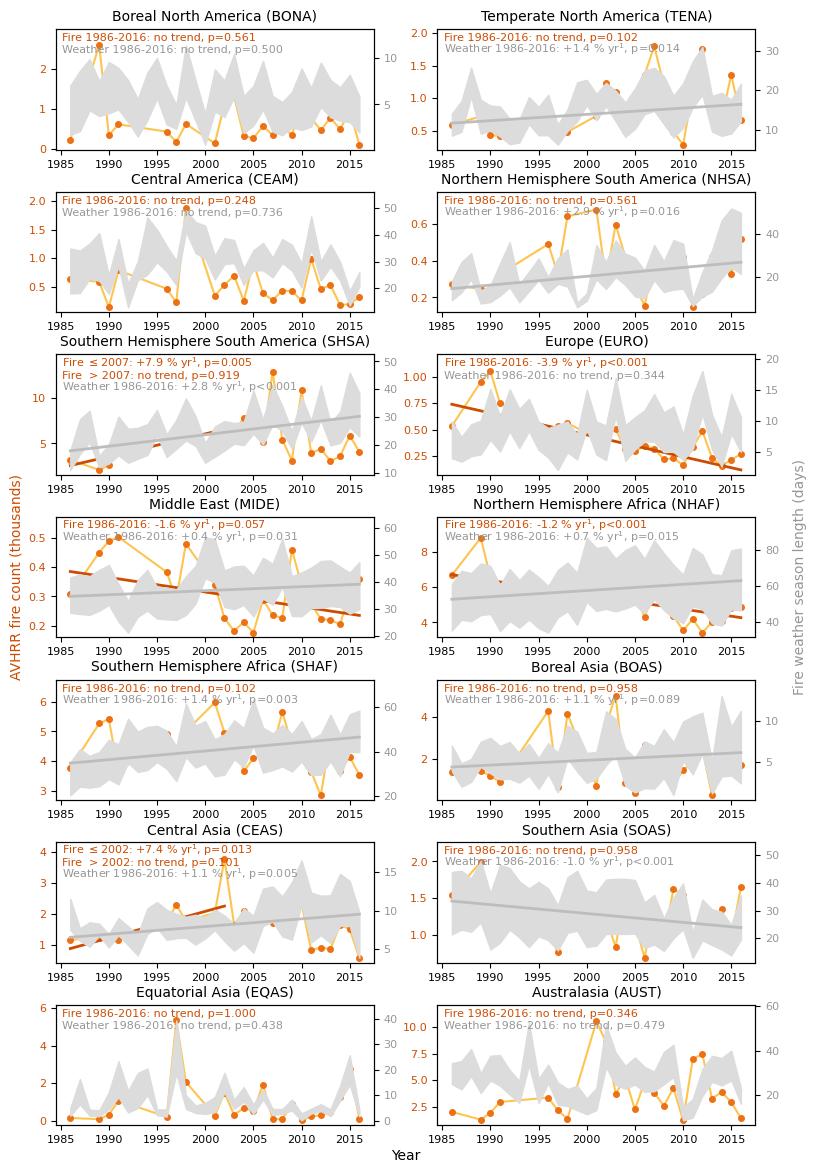

In [22]:
region_dict = {'BONA':  [None, None],
               'TENA':  [None, None], 
               'CEAM':  [None, None], 
               'NHSA':  [None, None],  
               'SHSA':  [2007, None],
               'EURO':  [None, None],
               'MIDE':  [None, None],
               'NHAF':  [None, None], 
               'SHAF':  [None, None], 
               'BOAS':  [None, None],
               'CEAS':  [2002, None], 
               'SOAS':  [None, None], 
               'EQAS':  [None, None],
               'AUST':  [None, None]
              }

## FLIPPED VERSIONS
fig, axes, stats_tbl = ts_plotter_fw_flip(df=df_outer, region_dict=region_dict, 
                           ylab1="Fire weather season length (days)",
                           ylab2="AVHRR fire count (thousands)",
                           xlab="Year", 
                           av_color_list=av_color_list, fw_color_list=fw_color_list, 
                            nrow=7, ncol=2, dim = (210*mm,297*mm))
fig.tight_layout()

# #figs
fig.savefig(os.path.join(dir_out_figures, 's5_timeseries_gfed_fwsl_flip.png'), dpi=1000)
fig.savefig(os.path.join(dir_out_figures, 's5_timeseries_gfed_fwsl_flip.pdf'))

# #statstable
stats_tbl.to_csv(str(dir_out_figures / 's5_timeseries_gfed_fwsl_flip.csv'), index=False)

### 2) FWSL - biome regions
* make timeseries plots for fire counts (ANF) and FWSL at Biome (temp/trop/boreal) level

In [23]:
# preprocess avhrr
df_ttb = pd.read_csv(str(fp_avhrr_ttb))

# make global and append
globe = df_ttb.groupby(['sat_yr', 'sat', 'year'])['count'].agg(['sum']).rename(columns={'sum':'count'}).reset_index()
globe['tropflag'] = 'Global'
df_ttb = pd.concat([df_ttb, globe])
# normalise to 1986
df86 = df_ttb.loc[df_ttb.year == 1986].rename(columns={'count':'count86'})
df_ttb = df_ttb.merge(df86[['tropflag','count86']], how='left', 
              on=['tropflag'])
df_ttb['ncount'] = df_ttb['count'] / df_ttb['count86']
df_ttb = df_ttb.drop('count86', axis=1)
df_ttb = df_ttb.rename(columns={'tropflag':'ttb_name'})

In [24]:
# preprocess fire weather
fwi_mem = pd.read_csv(str(fp_fwsl_ttb))

#first calc ensemble stats e.g. conf intervals, and then normalise afterwards with 1986 ensemblee mean
fwi_agg = fwi_mem.groupby(['ttb', 'ttb_name', 'year'])['fwsl_mean']\
 .agg(['count', 'mean', 'std', 'min', 'max'])\
 .reset_index()\
 .sort_values(['ttb', 'ttb_name', 'year'], ascending=True)

# ensemble mean values for 1986
fwi86 = fwi_agg.loc[fwi_agg.year == 1986].rename(columns={'mean':'mean86'})

# calc CIs: see https://www.mathsisfun.com/data/confidence-interval-calculator.html
fwi_agg['ci95'] = 1.96 * fwi_agg['std'].values / np.sqrt(fwi_agg['count'].values)
fwi_agg = fwi_agg.merge(fwi86[['ttb','ttb_name','mean86']],
                      how='left',
                      on=['ttb', 'ttb_name'])

#norm the ensemble stats
fwi_agg['n_mean'] = fwi_agg['mean'] / fwi_agg['mean86'] 
fwi_agg['n_min'] = fwi_agg['min'] / fwi_agg['mean86'] 
fwi_agg['n_max'] = fwi_agg['max'] / fwi_agg['mean86'] 
fwi_agg['n_std'] = fwi_agg['std'] / fwi_agg['mean86'] 
fwi_agg['n_ci95'] = fwi_agg['ci95'] / fwi_agg['mean86'] 

# also norm the ensemble members
fwi_mem = fwi_mem.merge(fwi86[['ttb', 'ttb_name','mean86']],
                         how='left', 
                         on=['ttb', 'ttb_name'])

fwi_mem['n_mean'] = fwi_mem['fwsl_mean'] / fwi_mem['mean86']

# drop unused
fwi_agg = fwi_agg.drop(['mean86','count'], axis=1)
fwi_mem = fwi_mem.drop(['mean86'], axis=1)

fwi_agg = fwi_agg.rename(columns={'mean':'fdi_mean', 'std':'fdi_std', 
                                  'min':'fdi_min', 'max':'fdi_max', 
                                  'ci95':'fdi_ci95', 
                                  'n_mean':'fdi_n_mean', 'n_std':'fdi_n_std',  
                                  'n_min':'fdi_n_min', 'n_max':'fdi_n_max', 
                                  'n_ci95':'fdi_n_ci95'})

fwi_agg.head()
np.unique(fwi_agg.ttb_name)

array(['Boreal', 'Global', 'Temperate', 'Tropics'], dtype=object)

In [25]:
# combine
df_outer = fwi_agg.merge(df_ttb, how='outer', on=['year','ttb_name'])
df_inner = fwi_agg.merge(df_ttb, how='inner', on=['year','ttb_name'])
df_inner.head()
#df_outer.head()

# use this file in R to get calculate trend break points:
df_outer.to_csv(str(dir_base / 'avhrr_and_fire_weather_fulljoin_1986-2016_TropTempBoreal.csv'), index=False)

plot biome data

In [26]:
# the plotting function is built for gfed regions and not very flexible; 
# so temporarily rename some cols

df_outer2 = df_outer.copy()
df_outer2 = df_outer2.rename(columns={'ttb_name': 'gfed_name', 
                         'ttb': 'gfed'
                                   }) 
df_outer2['gfed_full_name'] = df_outer2['gfed_name']
df_outer2[df_outer2.gfed_name=='Tropics'].head()

,gfed,gfed_name,year,fdi_mean,fdi_std,fdi_min,fdi_max,fdi_ci95,fdi_n_mean,fdi_n_min,fdi_n_max,fdi_n_std,fdi_n_ci95,sat_yr,sat,count,ncount,gfed_full_name
3,2,Tropics,1986,30.137487,8.884777,17.707429,39.672548,7.787851,1.000000,0.587555,1.316385,0.294808,0.258411,NF1986,NF,14250.0,1.000000,Tropics
7,2,Tropics,1987,38.840728,10.284145,25.088981,49.827452,9.014451,1.288785,0.832484,1.653338,0.341241,0.299111,NaN,NaN,NaN,NaN,Tropics
11,2,Tropics,1988,37.581751,10.671058,23.846954,48.073198,9.353595,1.247010,0.791272,1.595130,0.354079,0.310364,NaN,NaN,NaN,NaN,Tropics
15,2,Tropics,1989,33.462369,8.583669,21.732989,43.873462,7.523918,1.110324,0.721128,1.455777,0.284817,0.249653,NH1989,NH,15600.0,1.094737,Tropics
19,2,Tropics,1990,35.743999,9.848321,22.438942,45.089154,8.632434,1.186031,0.744553,1.496115,0.326780,0.286435,NH1990,NH,15142.0,1.062596,Tropics


C:\Users\mdejong\AppData\Local\Temp\ipykernel_164880\585173687.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


,region,metric,year_start,year_end,tau,p,intercept,slope,lower,upper
0,Tropics,fireweather,1986,2016,0.440860,0.000357,-16.671682,0.008981,0.003956,0.014381
1,Tropics,avhrr,1986,2016,-0.177866,0.248285,11.971632,-0.005386,-0.020218,0.005601
2,Temperate,fireweather,1986,2016,0.217204,0.089281,-7.432409,0.004234,-0.000640,0.008488
3,Temperate,avhrr,1986,2016,-0.035573,0.834573,6.026875,-0.002437,-0.019325,0.014596
4,Boreal,fireweather,1986,2016,0.126882,0.327104,-14.496918,0.007812,-0.004902,0.019704
5,Boreal,avhrr,1986,2016,-0.075099,0.638197,25.892808,-0.012294,-0.053118,0.039660
6,Global,fireweather,1986,2016,0.475269,0.000106,-13.614769,0.007405,0.004288,0.010711
7,Global,avhrr,1986,2016,-0.138340,0.373350,11.583899,-0.005155,-0.021265,0.004595
8,Global,avhrr,1986,2002,0.833333,0.000854,-67.487641,0.034436,0.021528,0.058599
9,Global,avhrr,2003,2016,-0.472527,0.019279,57.061226,-0.027786,-0.050339,-0.005153


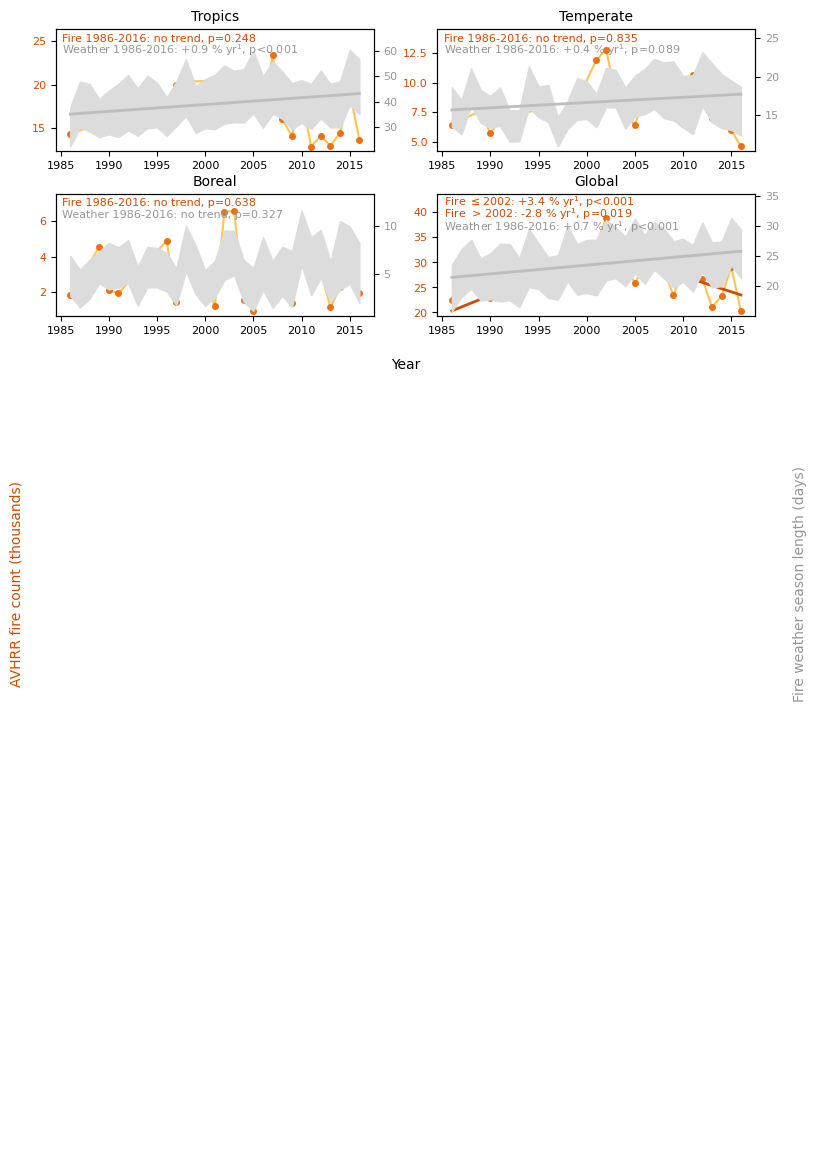

In [27]:
region_dict = {'Tropics':    [None, None],
               'Temperate':  [None, None],                
               'Boreal':     [None, None],
               'Global':     [2002, None]
               }

fig, axes, stats_tbl = ts_plotter_fw_flip(df=df_outer2, region_dict=region_dict, 
                           ylab1="Fire weather season length (days)",
                           ylab2="AVHRR fire count (thousands)",
                           xlab="Year", 
                           av_color_list=av_color_list, fw_color_list=fw_color_list, 
                            nrow=7, ncol=2, dim = (210*mm,297*mm), ax2rm=-0, xlabpad=-580)
fig.tight_layout()
for i in np.arange(-10,0):
    fig.delaxes(axes[i])

#figs
fig.savefig(str(dir_out_figures / 's5_timeseries_TTB_fwsl_flip.png'), dpi=1000)
fig.savefig(str(dir_out_figures / 's5_timeseries_TTB_fwsl_flip.pdf'))

#statstable
stats_tbl.to_csv(str(dir_out_figures / 's5_timeseries_TTB_fwsl_flip.csv'),index=False)
stats_tbl